In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from torch.ao.nn.quantized.functional import threshold

In [5]:
import matplotlib
import matplotlib.font_manager as fm

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name() # 폰트명
matplotlib.rc('font', family=font_name)

##  데이터 확인하기

In [6]:
# 데이터 불러오기
customers_df = pd.read_csv('data/olist_customers_dataset.csv')
sellers_df = pd.read_csv('data/olist_sellers_dataset.csv')
orders_df = pd.read_csv('data/olist_orders_dataset.csv')
products_df = pd.read_csv('data/olist_products_dataset.csv')
geolocation_df = pd.read_csv('data/olist_geolocation_dataset.csv')
order_items_df = pd.read_csv('data/olist_order_items_dataset.csv')
order_reviews_df = pd.read_csv('data/olist_order_reviews_dataset.csv')
categories_df = pd.read_csv('data/product_category_name_translation.csv')

In [117]:
# 데이터 확인
# display(customers_df.head())
# display(sellers_df.head())
# display(orders_df.head())
# display(products_df.head())
# display(geolocation_df.head())
display(order_items_df.head())
# display(order_reviews_df.head())
# display(categories_df.head())

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


## 이탈 기준 설정하기

#### 고객별 마지막 주문일 (전 구매자 대상)

In [8]:
orders_df = pd.read_csv("data/olist_orders_dataset.csv", parse_dates=['order_purchase_timestamp','order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])

In [9]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


평균 주문 경과일:  288 days 04:49:58.344135168


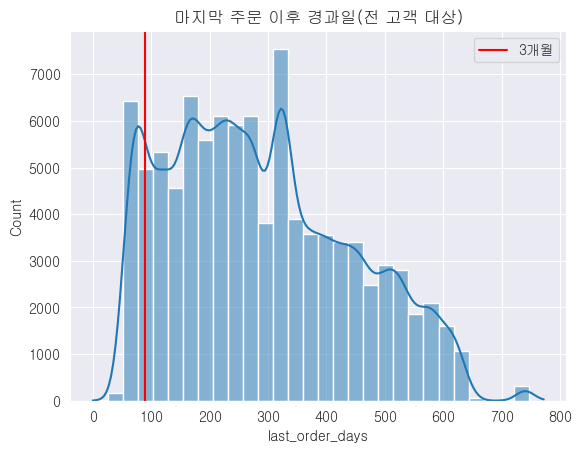

In [11]:
from datetime import datetime
# orders_df merge
orders_df = orders_df.merge(customers_df[['customer_id', 'customer_unique_id']], on='customer_id', how='left')
orders_df.head()

# 고객별 마지막 주문일
last_orders = orders_df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
# 최근 주문일
reference_date = orders_df['order_purchase_timestamp'].max()
last_orders['last_order_days'] = (reference_date - last_orders['order_purchase_timestamp']).dt.days
last_orders.head()
# 마지막 주문일 평균 - 최근 주문일 (288)
print('평균 주문 경과일: ', reference_date - last_orders['order_purchase_timestamp'].mean())
# print(last_orders.head())
# 시각화
sns.histplot(last_orders['last_order_days'], bins=30, kde=True)
plt.title('마지막 주문 이후 경과일(전 고객 대상)')
plt.axvline(90, color='red', linestyle='-', label='3개월') # 기준선
plt.legend()
plt.show()

#### 고객별 마지막 주문일 (재주문 구매자 대상)

In [13]:
# 재주문 고객 수 조회
# 9, 17회 주문 각 1명씩 조회
order_counts = orders_df.groupby('customer_unique_id')['order_id'].count()
print('재주문 구매자수: ', len(order_counts[order_counts > 1]))
# 재주문 구매자 주문 수 조회 (count > 2)
print('재주문 구매자 주문수: ', order_counts[order_counts > 1].sum())

# 재주문 고객 주문 수만 추출
# customer_user_id만 추출
reorders_id = order_counts[order_counts > 1].index
# is_reorder_cutomer 컬럼 추가 (재주문 대상 확인 가능)
last_orders['is_reorder_customer'] = last_orders['customer_unique_id'].isin(reorders_id)

재주문 구매자수:  2997
재주문 구매자 주문수:  6342


268.20687354020686


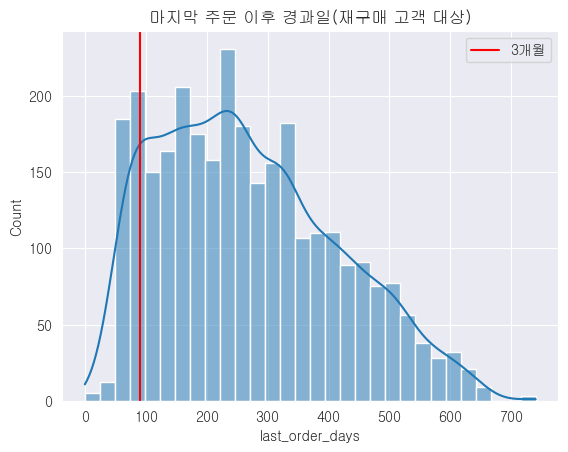

In [14]:
# 시각화
print(last_orders.query("is_reorder_customer")['last_order_days'].mean())
sns.histplot(
    last_orders.query("is_reorder_customer")['last_order_days'], # ==True 생략
             bins=30, kde=True)
plt.title('마지막 주문 이후 경과일(재구매 고객 대상)')
plt.axvline(90, color='red', linestyle='-', label='3개월') # 기준선
plt.legend()
plt.show()

#### 이탈 컬럼 추가 (재구매 90일 기준)

In [15]:
# 이탈 여부 라벨
last_orders['is_churn'] = last_orders.apply(lambda x: 1 if (x['is_reorder_customer'] and x['last_order_days'] > 90) else 0, axis=1) # axis
last_orders.head()

,customer_unique_id,order_purchase_timestamp,last_order_days,is_reorder_customer,is_churn
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,160,False,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,163,False,0
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,585,False,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,369,False,0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,336,False,0


In [16]:
# 재주문 고객만 필터링
last_orders = last_orders[last_orders['is_reorder_customer'] == 1]
last_orders.head()
# is_reorder_customer 컬럼 삭제 : 모두 True 값
last_orders.drop('is_reorder_customer', axis=1, inplace=True)

# 이탈 기준 라벨 추가
last_orders['churn'] = (last_orders['last_order_days'] > 90).astype(int)
last_orders.head()

,customer_unique_id,order_purchase_timestamp,last_order_days,is_churn,churn
33,00172711b30d52eea8b313a7f2cced02,2018-08-13 09:14:07,65,0,0
106,004288347e5e88a27ded2bb23747066c,2018-01-14 07:36:54,276,1,1
124,004b45ec5c64187465168251cd1c9c2f,2018-05-26 19:42:48,143,1,1
144,0058f300f57d7b93c477a131a59b36c3,2018-03-22 18:09:41,208,1,1
249,00a39521eb40f7012db50455bf083460,2018-06-03 10:12:57,136,1,1


##  배송관련 변수 병합 및 준비 (피처 생성)

In [17]:
last_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2997 entries, 33 to 96050
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        2997 non-null   object        
 1   order_purchase_timestamp  2997 non-null   datetime64[ns]
 2   last_order_days           2997 non-null   int64         
 3   is_churn                  2997 non-null   int64         
 4   churn                     2997 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 140.5+ KB


In [18]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   customer_unique_id             99441 non-null  object        
dtypes: datetime64[ns](5), object(4)
memory usage: 6.8+ MB


In [19]:
# 데이터 확인하기
# 주문상태 컬럼
orders_df['order_status'].unique()
# 예상 배송일
print('예상 배송일(이전):', orders_df['order_estimated_delivery_date'].min())
print('예상 배송일(최근):', orders_df['order_estimated_delivery_date'].max())
# 실제 배송일
print('실제 배송일(이전):', orders_df['order_delivered_customer_date'].min())
print('실제 배송일(최근):', orders_df['order_delivered_customer_date'].max())

예상 배송일(이전): 2016-09-30 00:00:00
예상 배송일(최근): 2018-11-12 00:00:00
실제 배송일(이전): 2016-10-11 13:46:32
실제 배송일(최근): 2018-10-17 13:22:46


In [20]:
orders_df.head()
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   customer_unique_id             99441 non-null  object        
dtypes: datetime64[ns](5), object(4)
memory usage: 6.8+ MB


### 탐색용 EDA

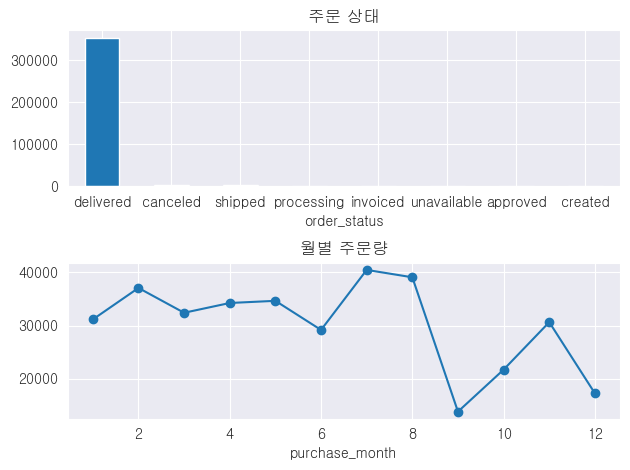

In [300]:
# 주문 상태
plt.subplot(2, 1, 1)
orders_df['order_status'].value_counts().plot(kind='bar')
plt.title('주문 상태')
plt.xticks(rotation=None)

# 월별 주문량
plt.subplot(2, 1, 2)
orders_df['purchase_month'] = orders_df['order_purchase_timestamp'].dt.month
orders_df['purchase_month'].value_counts().sort_index().plot(kind='line', marker='o')
plt.xticks(rotation=None)
plt.title('월별 주문량')
plt.tight_layout()

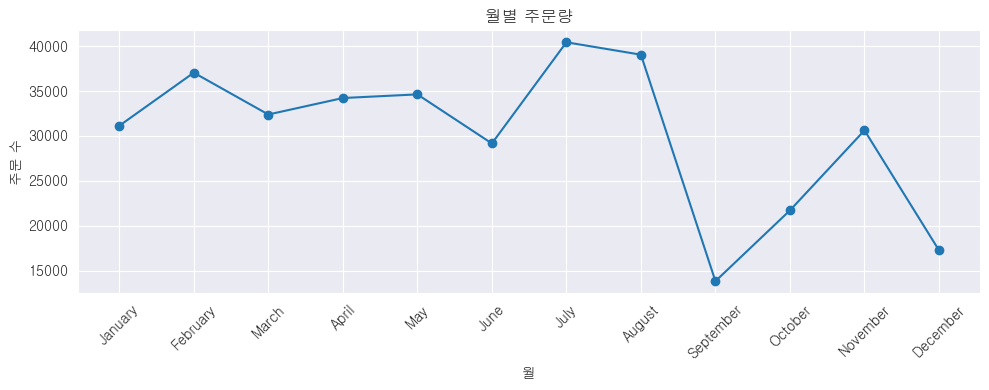

In [328]:
import calendar

# 1. 월 이름 만들기 (올바르게!)
orders_df['purchase_month'] = orders_df['order_purchase_timestamp'].dt.month_name()

# 2. 월 순서 정렬을 위한 카테고리 설정
month_order = list(calendar.month_name)[1:]  # ['January', ..., 'December']
orders_df['purchase_month'] = pd.Categorical(orders_df['purchase_month'], categories=month_order, ordered=True)

# 3. 월별 주문 수 집계
monthly_orders = orders_df['purchase_month'].value_counts().sort_index()

# 4. 시각화
plt.figure(figsize=(10, 4))
plt.plot(monthly_orders.index, monthly_orders.values, marker='o', linestyle='-')
plt.title('월별 주문량')
plt.xlabel('월')
plt.ylabel('주문 수')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


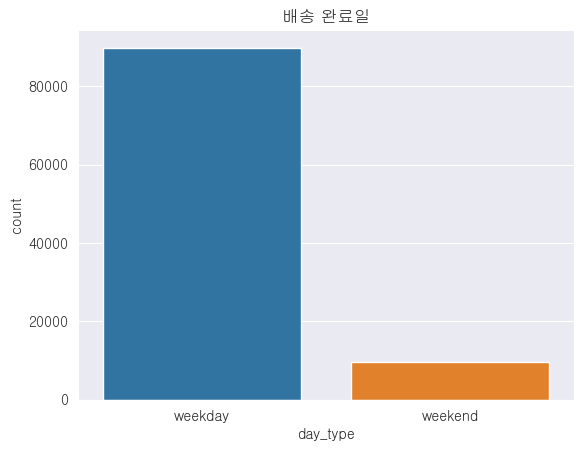

In [48]:
# 평일-주말 주문량
# dt.dayofweek : 0=월요일 ~ 6=일요일
orders_df['day_type'] = orders_df['order_delivered_customer_date'].dt.dayofweek.apply(lambda x: 'weekday' if x < 5 else 'weekend')
orders_df.head()
sns.countplot(orders_df, x='day_type', hue='day_type')
# plt.legend()
plt.title('배송 완료일')
plt.show()

In [65]:
# 배송누락율 0.02981
print(orders_df['order_delivered_customer_date'].isna().mean())
# 이외 컬럼 누락율
print(orders_df.isnull().mean().sort_values(ascending=False))

0.02981667521444877
delay_days                       0.029817
order_delivered_customer_date    0.029817
order_delivered_carrier_date     0.017930
order_approved_at                0.001609
order_purchase_timestamp         0.000000
order_status                     0.000000
customer_id                      0.000000
order_id                         0.000000
order_estimated_delivery_date    0.000000
customer_unique_id               0.000000
purchase_month                   0.000000
day_type                         0.000000
dtype: float64


소비자와 판매자 사이 거리는 얼마나 멀까?

### 배송 관련 변수 선언

26243


Text(0.5, 1.0, '배송 지연일 분포')

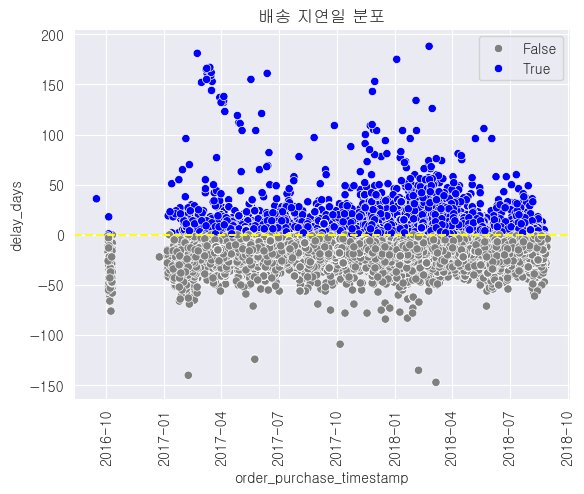

In [252]:
# 배송 지연일 계산
orders_df['delay_days'] = (orders_df['order_delivered_customer_date'] - orders_df['order_estimated_delivery_date']).dt.days
orders_df.head()
# 배송 지연일 > 0, 양수일때
orders_df[orders_df['delay_days'] > 0].head()
print(orders_df['delay_days'][orders_df['delay_days'] > 0].count())
# 시각화
sns.scatterplot(orders_df, x='order_purchase_timestamp', y='delay_days', hue=orders_df['delay_days'] > 0, palette={True: 'blue', False: 'grey'})
plt.axhline(0, color='yellow', linestyle='--')
plt.legend()
plt.xticks(rotation=90)
plt.title('배송 지연일 분포')

In [139]:
# 배송 소요일
orders_df['processing_days'] = (orders_df['order_delivered_customer_date'] - orders_df['order_purchase_timestamp']).dt.days

# 결제 승인까지 걸린 시간
orders_df['approval_days'] = (orders_df['order_approved_at'] - orders_df['order_purchase_timestamp']).dt.days

# 배송 누락 여부
# 배송일이 비어있거나 오래전 주문인데 아직 배송이 안 된 경우(90일)
print(reference_date)
orders_df['delivery_missing'] = (
        orders_df['order_delivered_customer_date'].isna() &
        ((reference_date - orders_df['order_purchase_timestamp']).dt.days > 90)).astype(int)

# 배송 완료 여부
orders_df['is_delivered'] = (orders_df['order_delivered_customer_date'].notnull()).astype(int)
# orders_df['is_delivered'] = (orders_df['order_status'] == 'delivered').astype(int)

# 주문 당 평균 배송비
avg_freight = order_items_df.groupby('order_id')['freight_value'].mean().reset_index()
orders_df = pd.merge(orders_df, avg_freight, on='order_id', how='left')

# 고객 정보
orders_df = pd.merge(orders_df, customers_df[['customer_id', 'customer_state']], on='customer_id', how='left')

print(orders_df.info())
orders_df.head()

2018-10-17 17:30:18
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361537 entries, 0 to 361536
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   order_id                       361537 non-null  object         
 1   customer_id                    361537 non-null  object         
 2   order_status                   361537 non-null  object         
 3   order_purchase_timestamp       361537 non-null  datetime64[ns] 
 4   order_approved_at              361370 non-null  datetime64[ns] 
 5   order_delivered_carrier_date   356017 non-null  datetime64[ns] 
 6   order_delivered_customer_date  353796 non-null  datetime64[ns] 
 7   order_estimated_delivery_date  361537 non-null  datetime64[ns] 
 8   customer_unique_id             361537 non-null  object         
 9   purchase_month                 361537 non-null  int32          
 10  day_type                       36153

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,purchase_month,day_type,delay_days,shipping_time,approval_time,processing_days,approval_days,is_delivered,delivery_missing,customer_state,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,10,weekday,-8.0,8 days 10:28:40,0 days 00:10:42,8.0,0.0,1,0,SP,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,7,weekday,-6.0,13 days 18:46:08,1 days 06:42:50,13.0,1.0,1,0,BA,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,8,weekday,-18.0,9 days 09:27:40,0 days 00:16:34,9.0,0.0,1,0,GO,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,11,weekend,-13.0,13 days 05:00:36,0 days 00:17:53,13.0,0.0,1,0,RN,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,2,weekday,-10.0,2 days 20:58:23,0 days 01:01:50,2.0,0.0,1,0,SP,8.72


In [138]:
# 주문 ID별 상품 개수
order_item_counts = order_items_df.groupby('order_id')['order_item_id'].count()

# 여러 개의 상품을 가진 주문 확인
print("상품이 2개 이상인 주문 수:", (order_item_counts > 1).sum())
print(order_item_counts.value_counts().sort_index())  # 상품 수 분포

# 동일한 주문 ID의 freight_value 확인 (샘플)
sample = order_items_df[order_items_df['order_id'].duplicated(keep=False)]
sample[['order_id', 'freight_value']].sort_values(by='order_id').head(10)

# 주문별 유일한 배송비 개수
unique_freight_count = order_items_df.groupby('order_id')['freight_value'].nunique()
print("freight_value가 동일한 주문 수:", (unique_freight_count == 1).sum())
print("freight_value가 서로 다른 주문 수:", (unique_freight_count > 1).sum())

상품이 2개 이상인 주문 수: 9803
order_item_id
1     88863
2      7516
3      1322
4       505
5       204
6       198
7        22
8         8
9         3
10        8
11        4
12        5
13        1
14        2
15        2
20        2
21        1
Name: count, dtype: int64
freight_value가 동일한 주문 수: 96636
freight_value가 서로 다른 주문 수: 2030


In [145]:
# 컬럼 삭제
orders_df.drop(
    columns=['shipping_time', 'approval_time'],
    errors='ignore',  # 혹시 없으면 무시
    inplace=True
)

#### 피처별 수치형 상관관계

In [175]:
orders_df.info()
print(orders_df[['is_delivered', 'delivery_missing']].dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361537 entries, 0 to 361536
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       361537 non-null  object        
 1   customer_id                    361537 non-null  object        
 2   order_status                   361537 non-null  object        
 3   order_purchase_timestamp       361537 non-null  datetime64[ns]
 4   order_approved_at              361370 non-null  datetime64[ns]
 5   order_delivered_carrier_date   356017 non-null  datetime64[ns]
 6   order_delivered_customer_date  353796 non-null  datetime64[ns]
 7   order_estimated_delivery_date  361537 non-null  datetime64[ns]
 8   customer_unique_id             361537 non-null  object        
 9   purchase_month                 361537 non-null  int32         
 10  day_type                       361537 non-null  object        
 11  

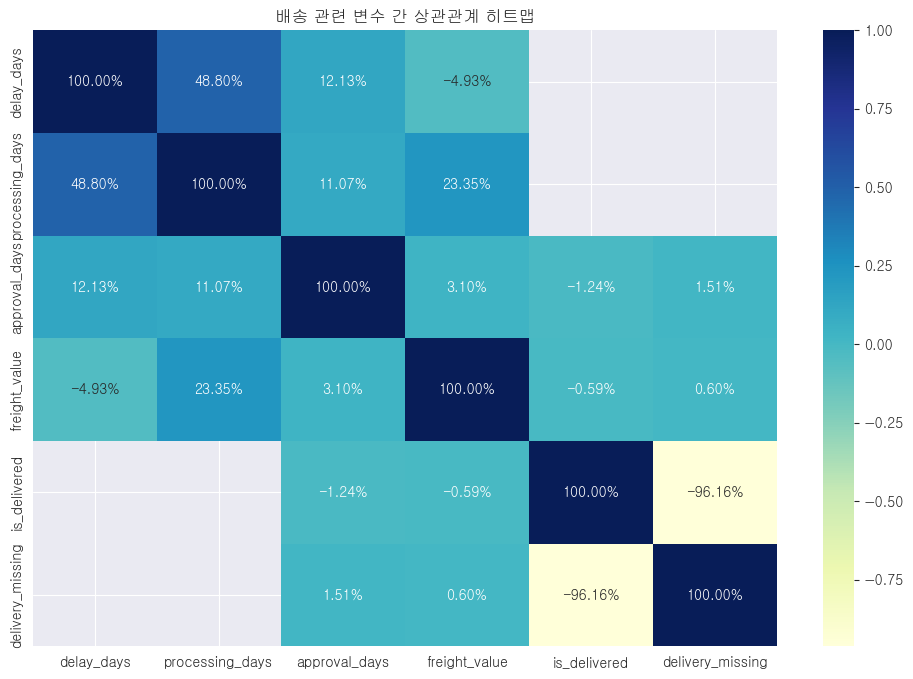

In [167]:
# 수치형 변수만 추출
num_cols = ['delay_days', 'processing_days', 'approval_days', 'freight_value', 'is_delivered', 'delivery_missing']
# 시각화
plt.figure(figsize = (12, 8))
corr = orders_df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='YlGnBu', fmt='.2%')
plt.title('배송 관련 변수 간 상관관계 히트맵')
plt.show()

In [151]:
# 히트맵 결측치 확인
orders_df[['delay_days', 'processing_days', 'approval_days', 'freight_value', 'is_delivered', 'delivery_missing']].corr()

print(orders_df[['is_delivered', 'delivery_missing']].isnull().sum())

,delay_days,processing_days,approval_days,freight_value,is_delivered,delivery_missing
delay_days,1.000000,0.488004,0.121309,-0.049268,NaN,NaN
processing_days,0.488004,1.000000,0.110720,0.233507,NaN,NaN
approval_days,0.121309,0.110720,1.000000,0.030980,-0.012391,0.015086
freight_value,-0.049268,0.233507,0.030980,1.000000,-0.005947,0.005987
is_delivered,NaN,NaN,-0.012391,-0.005947,1.000000,-0.961636
delivery_missing,NaN,NaN,0.015086,0.005987,-0.961636,1.000000


<Figure size 1200x800 with 0 Axes>

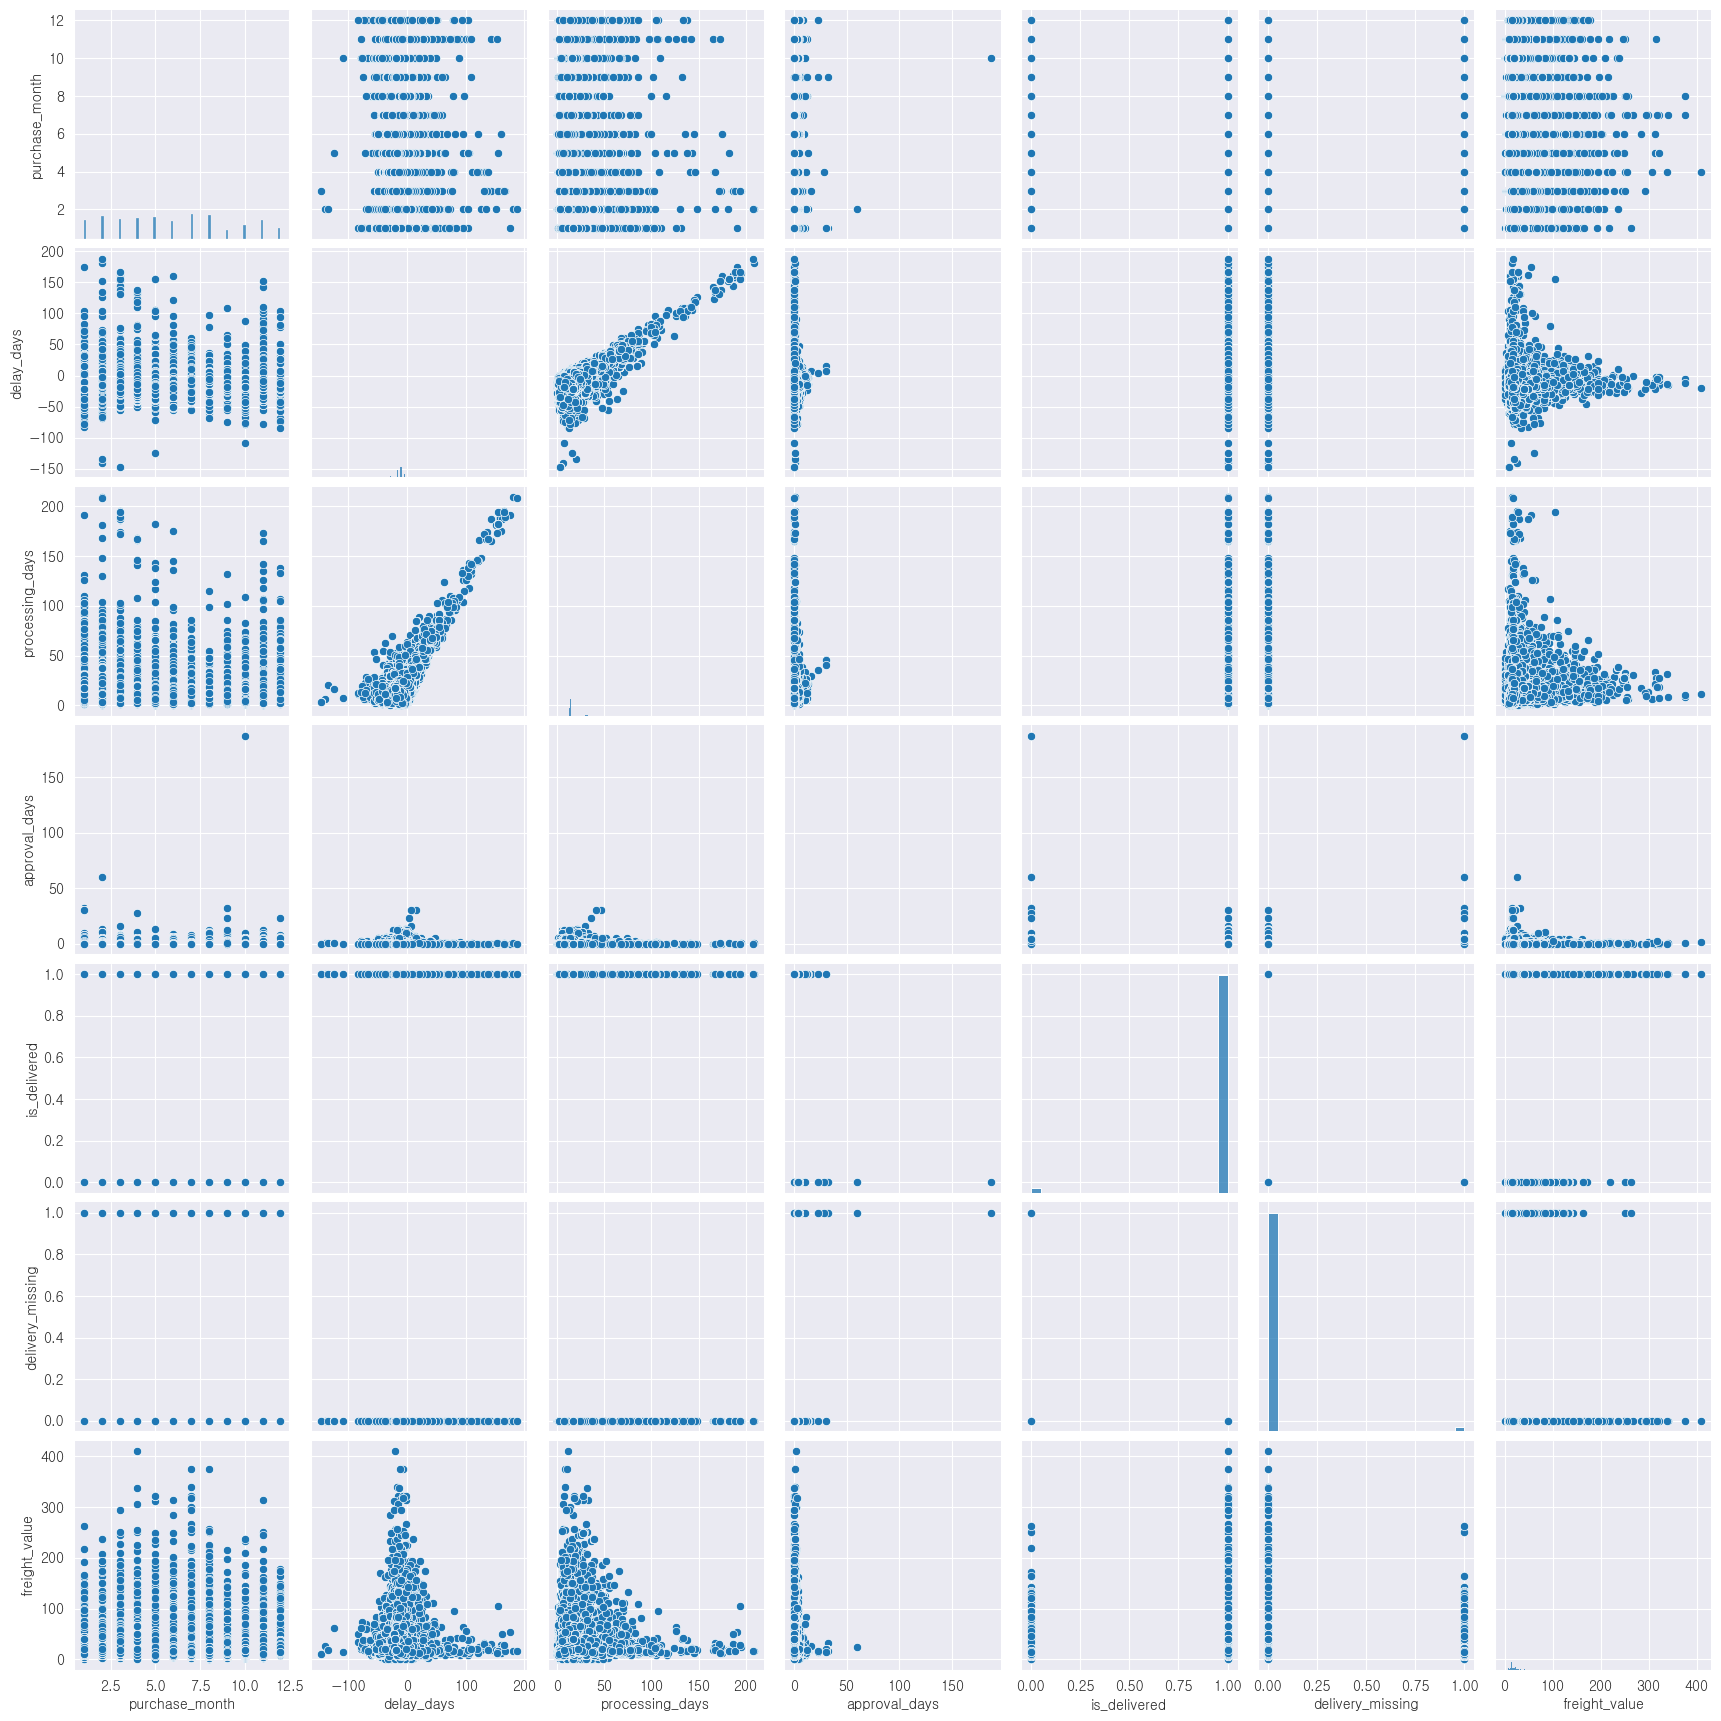

In [168]:
plt.figure(figsize = (12, 8))
sns.pairplot(orders_df[num_cols])

In [178]:
last_orders.columns
orders_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'purchase_month', 'day_type', 'delay_days',
       'processing_days', 'approval_days', 'is_delivered', 'delivery_missing',
       'customer_state', 'freight_value'],
      dtype='object')

### 모델링 변수 병합

In [209]:
# 사용할 배송 관련 변수
delivery_cols = ['delay_days', 'processing_days', 'approval_days', 'freight_value', 'is_delivered', 'delivery_missing']
delivery_num_cols = ['delay_days', 'processing_days', 'approval_days', 'freight_value']
delivery_bin_cols = ['is_delivered', 'delivery_missing']

# 고객별 평균 집계 (order_id 여러 개를 가진 고객에 대한 평균)
# 0과 1 값은 비율 혹은 합계로 처리
delivery_num_features = orders_df.groupby('customer_unique_id')[delivery_num_cols].mean().reset_index()
delivery_bin_features = orders_df.groupby('customer_unique_id')[delivery_bin_cols].mean().reset_index()

# 병합: last_orders + 배송 요약 변수
delivery_features = pd.merge(delivery_num_features, delivery_bin_features, on='customer_unique_id', how='outer')
model_df = pd.merge(last_orders, delivery_features, on='customer_unique_id', how='left')
print(model_df['delay_days'][model_df['delay_days'] > 0].count())
model_df.head()

119


,customer_unique_id,order_purchase_timestamp,last_order_days,is_churn,delay_days,processing_days,approval_days,freight_value,is_delivered,delivery_missing
0,00172711b30d52eea8b313a7f2cced02,2018-08-13 09:14:07,65,0,-15.0,10.0,0.0,47.57,0.5,0.0
1,004288347e5e88a27ded2bb23747066c,2018-01-14 07:36:54,276,1,-17.5,6.5,0.0,18.24,1.0,0.0
2,004b45ec5c64187465168251cd1c9c2f,2018-05-26 19:42:48,143,1,-22.0,23.0,2.5,30.41,0.5,0.5
3,0058f300f57d7b93c477a131a59b36c3,2018-03-22 18:09:41,208,1,-12.0,13.0,0.0,21.55,0.5,0.5
4,00a39521eb40f7012db50455bf083460,2018-06-03 10:12:57,136,1,-19.0,17.5,0.0,20.90,1.0,0.0


In [188]:
# 타깃 (이탈 여부)
y = model_df['is_churn']

# 피처 (배송 관련 변수)
X = model_df[delivery_cols]

#### 결측치 처리

In [225]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 결측치 처리 - 0으로 처리하는게 맞나 흠..
X = X.fillna(0)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(2397, 6) (2397,)
(600, 6) (600,)


#### 모델 사용

In [255]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 모델 훈련
log_clf = LogisticRegression(
    class_weight='balanced',
    C= 0.1,
    solver='liblinear',
    max_iter=500,
)
log_clf.fit(X_train_scaled, y_train)

# 모델 예측 및 평가
y_pred = log_clf.predict(X_test_scaled)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 52  19]
 [178 351]]
              precision    recall  f1-score   support

           0       0.23      0.73      0.35        71
           1       0.95      0.66      0.78       529

    accuracy                           0.67       600
   macro avg       0.59      0.70      0.56       600
weighted avg       0.86      0.67      0.73       600



#### GridSearchCV

In [256]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'class_weight':['balanced', None],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear'],
    'penalty': ['l1', 'l2']
}
grid = GridSearchCV(LogisticRegression(max_iter=500), param_grid=param_grid, cv=5, scoring='accuracy' )
grid.fit(X_train_scaled, y_train)

print('Best params:', grid.best_params_)
print('Best accuracy:', grid.best_score_)

Best params: {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Best accuracy: 0.8944545929018789


In [316]:
last_orders.columns

Index(['customer_unique_id', 'order_purchase_timestamp', 'last_order_days',
       'is_churn'],
      dtype='object')

            Feature  Coefficient
1   processing_days     1.093701
5  delivery_missing     1.066531
4      is_delivered     0.956356
0        delay_days    -0.587611
3     freight_value    -0.393869
2     approval_days    -0.040358


C:\Users\Playdata2\AppData\Local\Temp\ipykernel_24700\2245558831.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Coefficient', y='Feature', palette='coolwarm')


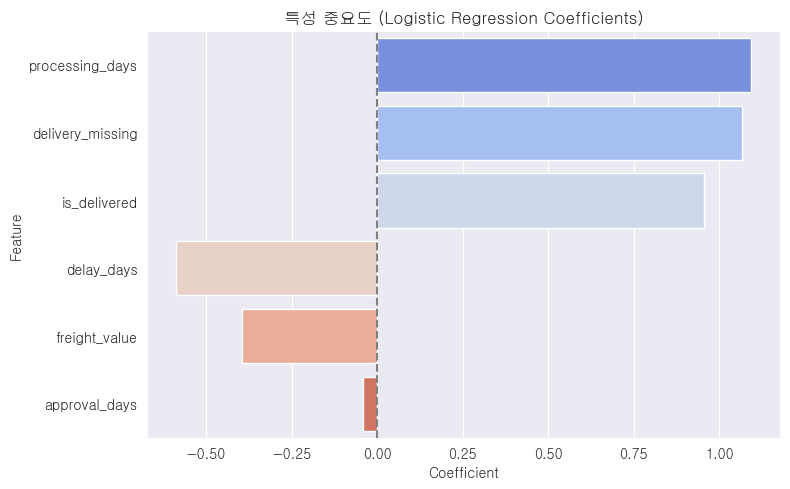

In [257]:
# 각 배송 변수의 영향력 해석
import pandas as pd

importance_df = pd.DataFrame({
    'Feature': delivery_cols,
    'Coefficient': log_clf.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(importance_df)

# 시각화
plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='Coefficient', y='Feature', palette='coolwarm')

plt.title('특성 중요도 (Logistic Regression Coefficients)')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

#### 취소/품절 변수

In [262]:
# 품절 경험자
unavailable_customers = orders_df[orders_df['order_status'] == 'unavailable']['customer_unique_id'].unique()

# 품절 경험자 이탈률 계산
churn_unavailable = last_orders[last_orders['customer_unique_id'].isin(unavailable_customers)]['is_churn'].mean()
print(f'품절 경험자 이탈률: {churn_unavailable:.2%}')

# 주문취소 경험자
canceled_customers = orders_df[orders_df['order_status'] == 'canceled']['customer_unique_id'].unique()

# 주문취소 이탈률 계산
churn_canceled = last_orders[last_orders['customer_unique_id'].isin(canceled_customers)]['is_churn'].mean()
print(f'주문취소 경험자 이탈률: {churn_canceled:.2%}')


# 품절 경험 없는 고객
churn_no_unavailable = last_orders[~last_orders['customer_unique_id'].isin(unavailable_customers)]['is_churn'].mean()
print(f'품절 미경험자 이탈률: {churn_no_unavailable:.2%}')

# 취소 경험 없는 고객
churn_no_canceled = last_orders[~last_orders['customer_unique_id'].isin(canceled_customers)]['is_churn'].mean()
print(f'주문취소 미경험자 이탈률: {churn_no_canceled:.2%}')

품절 경험자 이탈률: 92.31%
주문취소 경험자 이탈률: 54.22%
품절 미경험자 이탈률: 88.17%
주문취소 미경험자 이탈률: 89.19%


In [327]:
print(orders_df['delay_days'].max())

plt.figure(figsize=(10, 5))
sns.histplot(orders_df['delay_days']['customer_unique_id'] > 0, kde=True, bins=30, color='blue')
plt.title('배송 지연일 분포')
plt.xlabel('delay_days')
plt.axvline(0, color='yellow', linestyle='--', label='예상 배송일')
plt.legend()
plt.tight_layout()
plt.show()

188.0


KeyError: 'customer_unique_id'

<Figure size 1000x500 with 0 Axes>

In [326]:
plt.figure(figsize=(7, 4))
sns.boxplot(data=last_orders, x='is_churn', y='delay_days', palette='Set2')
plt.xticks([0, 1], ['비이탈', '이탈'])
plt.title('이탈 여부에 따른 delay_days 분포')
plt.xlabel('이탈 여부')
plt.ylabel('delay_days')
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

ValueError: Could not interpret value `delay_days` for `y`. An entry with this name does not appear in `data`.

<Figure size 700x400 with 0 Axes>

In [324]:
churn_rate_delayed = model_df[model_df['delay_days'] > 0]['is_churn'].mean()
print(f"배송 지연된 고객 이탈률: {churn_rate_delayed:.2%}")

churn_rate_early = model_df[model_df['delay_days'] < 0]['is_churn'].mean()
print(f"배송이 빠른 고객 이탈률: {churn_rate_early:.2%}")

배송 지연된 고객 이탈률: 94.12%
배송이 빠른 고객 이탈률: 88.20%
